In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from dateutil.relativedelta import relativedelta
import psycopg2
from pylab import rcParams
#rcParams['figure.figsize'] = 15, 7

In [2]:
files = ['095-106 оборот розничной торговли.xls', '05-01 оборот розничной торговли.xls']
file_indicators = [[9, 1], [10, 3], [11, 4], [12, 2]]

In [3]:
def connect_database():
    connection = psycopg2.connect(
        host = '',
        port = 5432,
        user = 'postgres',
        password = 'postgres',
        database='postgres' )
    connection.autocommit = False
    cursor = connection.cursor()
    return connection, cursor

In [4]:
def select_file_data_from_region_period_indicators(filename1, filename2):
    command = (
        'select p.value, r.name, rpi.value, rpi.indicator_id, rpi.region_id '
        'from data.region_period_indicators rpi '
        'join data.periods p on rpi.period_id = p.id '
        'join data.regions r on rpi.region_id = r.id '
        'join data.incoming_files if on rpi.file_id = if.id '
        'where if.filename = \'{0}\' or if.filename = \'{1}\'').format(filename1, filename2)
    cursor.execute(command)
    return cursor.fetchall()

In [5]:
def region_values(region, data, accumulated=False):
    tmp = data.loc[data.region == region]
    region_id = tmp['region_id'][0]
    tmp = tmp[['value']]
    tmp.sort_index(inplace=True)
    if accumulated:
        last = 0
        for i in range(len(tmp.index)):
            value = tmp.iloc[i][0]
            if tmp.index[i].month != 1:
                ind = tmp.index[i]
                tmp.loc[ind, 'value'] = value - last
            last = value
    return tmp, region_id

In [6]:
def indicator_data(indicators):
    result = pd.DataFrame()
    for i in indicators:
        tmp = df.loc[df['indicator_id'] == i]
        result = result.append(tmp)
    return result

In [7]:
connection, cursor = connect_database()

In [8]:
data = select_file_data_from_region_period_indicators(files[0], files[1])
df = pd.DataFrame(list(map(np.ravel, data)), columns=['date', 'region', 'value', 'indicator_id', 'region_id'])
df.set_index('date', inplace=True)
subjects = np.unique(df['region'])

In [9]:
subjects

array(['Алтайский край', 'Амурская область', 'Архангельская область',
       'Астраханская область', 'Белгородская область', 'Брянская область',
       'Владимирская область', 'Волгоградская область',
       'Вологодская область', 'Воронежская область',
       'Дальневосточный федеральный округ',
       'Еврейская автономная область', 'Забайкальский край',
       'Ивановская область', 'Иркутская область',
       'Кабардино-Балкарская Республика', 'Калининградская область',
       'Калужская область', 'Камчатский край',
       'Карачаево-Черкесская Республика', 'Кемеровская область',
       'Кировская область', 'Костромская область', 'Краснодарский край',
       'Красноярский край', 'Курганская область', 'Курская область',
       'Ленинградская область', 'Липецкая область', 'Магаданская область',
       'Московская область', 'Мурманская область',
       'Ненецкий автономный округ', 'Нижегородская область',
       'Новгородская область', 'Новосибирская область', 'Омская область',
       

In [10]:
subject = subjects[7]

In [11]:
indicators_data = indicator_data(file_indicators[0])

In [12]:
tmp, region_id = region_values(subject, indicators_data, True)

In [13]:
tmp

,value
date,
2009-01-01,16915.6
2009-02-01,17081.3
2009-03-01,16810.2
2009-04-01,16228.9
2009-05-01,16625.4
...,...
2020-12-01,41372.1
2021-01-01,34991.5
2021-02-01,35491.5


In [14]:
type(tmp)

pandas.core.frame.DataFrame

In [15]:
%pylab inline
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

def plot_region(data):
    plt.figure(figsize(15,7))
    plt.title(subject)
    
    plot(data, label='Оборот розничной торговли')
    plt.legend()
    pylab.show()

Populating the interactive namespace from numpy and matplotlib


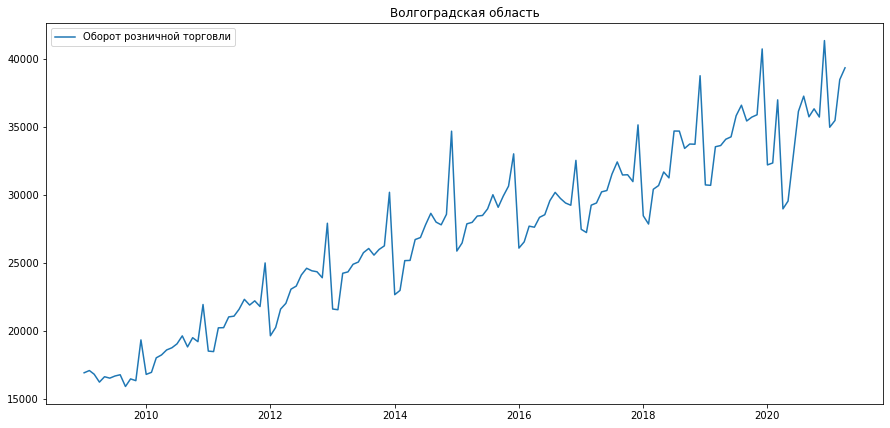

In [16]:
plot_region(tmp)

In [17]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

numpy.random.seed(7)

In [18]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [19]:
dataset = tmp.values
dataset = dataset.astype('float32')

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [21]:
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [40]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [41]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [42]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=30, batch_size=1, verbose=2)

Epoch 1/30
101/101 - 0s - loss: 0.0755
Epoch 2/30
101/101 - 0s - loss: 0.0314
Epoch 3/30
101/101 - 0s - loss: 0.0219
Epoch 4/30
101/101 - 0s - loss: 0.0195
Epoch 5/30
101/101 - 0s - loss: 0.0176
Epoch 6/30
101/101 - 0s - loss: 0.0160
Epoch 7/30
101/101 - 0s - loss: 0.0144
Epoch 8/30
101/101 - 0s - loss: 0.0129
Epoch 9/30
101/101 - 0s - loss: 0.0117
Epoch 10/30
101/101 - 0s - loss: 0.0104
Epoch 11/30
101/101 - 0s - loss: 0.0096
Epoch 12/30
101/101 - 0s - loss: 0.0087
Epoch 13/30
101/101 - 0s - loss: 0.0082
Epoch 14/30
101/101 - 0s - loss: 0.0077
Epoch 15/30
101/101 - 0s - loss: 0.0075
Epoch 16/30
101/101 - 0s - loss: 0.0071
Epoch 17/30
101/101 - 0s - loss: 0.0069
Epoch 18/30
101/101 - 0s - loss: 0.0068
Epoch 19/30
101/101 - 0s - loss: 0.0067
Epoch 20/30
101/101 - 0s - loss: 0.0067
Epoch 21/30
101/101 - 0s - loss: 0.0067
Epoch 22/30
101/101 - 0s - loss: 0.0067
Epoch 23/30
101/101 - 0s - loss: 0.0067
Epoch 24/30
101/101 - 0s - loss: 0.0066
Epoch 25/30
101/101 - 0s - loss: 0.0066
Epoch 26/

In [43]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [44]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [45]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2032.91 RMSE
Test Score: 3327.60 RMSE


In [46]:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [47]:
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

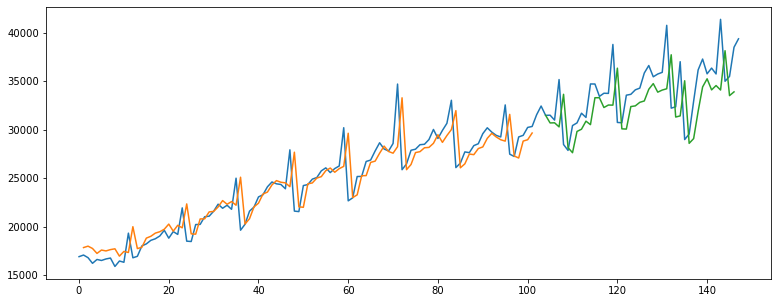

In [50]:
plt.figure(figsize(13,5))
plt.plot(scaler.inverse_transform(dataset), label='Оборот розничной торговли')
plt.plot(trainPredictPlot, label='Прогнозирование для тренировочной выборки')
plt.plot(testPredictPlot, label='Прогнозирование для тестовой выборки')
plt.show()